## 04. Transfer Learning w/ TensorFlow Part 1: Feature Extraction

In [1]:
# Add timestamp
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2023-10-14 07:40:51.089735


In [1]:
# Are we using a GPU?
!nvidia-smi

Sat Oct 14 07:41:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Downloading and becoming one with the data

In [2]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-10-14 08:30:02--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.207, 108.177.126.207, 108.177.127.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  41.5MB/s    in 4.5s    

2023-10-14 08:30:07 (35.9 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent

### Creating data loaders (preparing the data)

In [4]:
import tensorflow as tf

In [5]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Tetsting images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Tetsting images:
Found 2500 images belonging to 10 classes.


### Setting up callbacks (things to run whilst our model trains)

In [6]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

### Create models using TensorFlow Hub

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [9]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
  model_url (str): A TensorFlow Hub feature extraction URL.
  num_classes (int): Number of ourput neurons in ourput layer,
    should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer, # use the feature extraction layer as the base
      layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layre
  ])

  return model

In [10]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [11]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20231014-083022
Epoch 1/5
24/24 [==============================] - 29s 648ms/step - loss: 1.9950 - accuracy: 0.3507 - val_loss: 1.2711 - val_accuracy: 0.5820
Epoch 2/5
24/24 [==============================] - 13s 548ms/step - loss: 0.9367 - accuracy: 0.7053 - val_loss: 0.8960 - val_accuracy: 0.7052
Epoch 3/5
24/24 [==============================] - 11s 476ms/step - loss: 0.6375 - accuracy: 0.8133 - val_loss: 0.7860 - val_accuracy: 0.7428
Epoch 4/5
24/24 [==============================] - 12s 512ms/step - loss: 0.4835 - accuracy: 0.8640 - val_loss: 0.7026 - val_accuracy: 0.7716
Epoch 5/5
24/24 [==============================] - 11s 467ms/step - loss: 0.3818 - accuracy: 0.9093 - val_loss: 0.6827 - val_accuracy: 0.7748


In [15]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

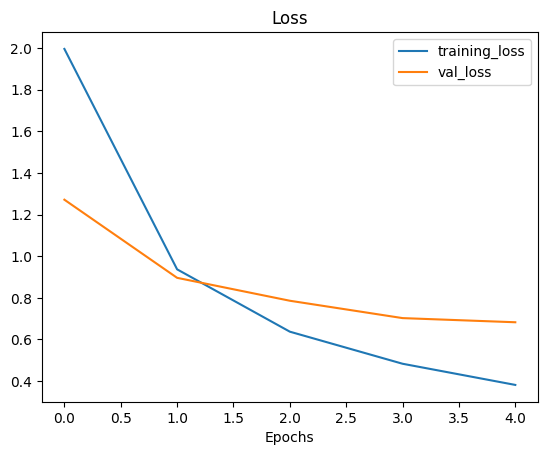

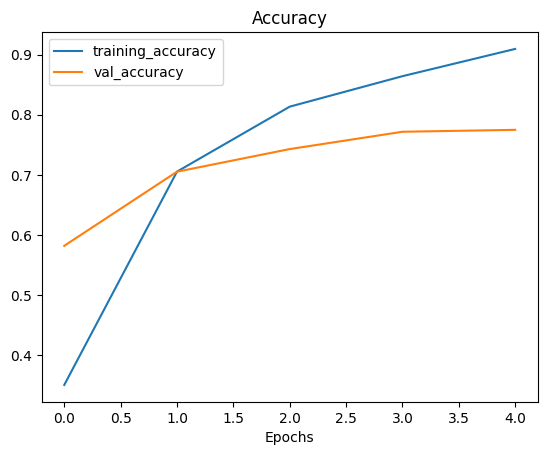

In [16]:
plot_loss_curves(resnet_history)

In [17]:
# ResNet summary
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [18]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # use only 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                                     # Track logs under different experiment names
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20231014-083332
Epoch 1/5
24/24 [==============================] - 23s 530ms/step - loss: 1.8645 - accuracy: 0.4280 - val_loss: 1.3106 - val_accuracy: 0.7360
Epoch 2/5
24/24 [==============================] - 10s 445ms/step - loss: 1.0626 - accuracy: 0.7800 - val_loss: 0.8752 - val_accuracy: 0.8072
Epoch 3/5
24/24 [==============================] - 13s 540ms/step - loss: 0.7573 - accuracy: 0.8320 - val_loss: 0.7038 - val_accuracy: 0.8336
Epoch 4/5
24/24 [==============================] - 10s 450ms/step - loss: 0.6058 - accuracy: 0.8693 - val_loss: 0.6180 - val_accuracy: 0.8480
Epoch 5/5
24/24 [==============================] - 10s 407ms/step - loss: 0.5109 - accuracy: 0.8920 - val_loss: 0.5639 - val_accuracy: 0.8568


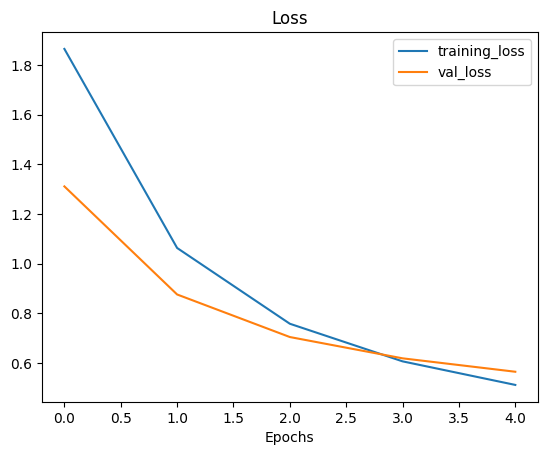

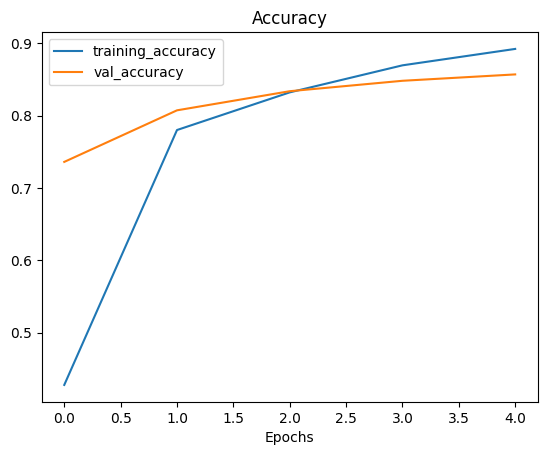

In [19]:
plot_loss_curves(efficientnet_history)

In [20]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


### Comparing models using TensorBoard

In [21]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing 2 different TF Hub Feature Extraction model architectures using 10% of training images" \
  --one_shot

2023-10-14 08:34:41.649535: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.10/dist-packages/tensorboard/main.py", line 46, in run_main
  File "/usr/local/lib/python3.10/dist-packages/absl/app

In [22]:
# Check out experiments
# !tensorboard dev list # uncomment to see

In [25]:
# Delete an experiment
!tensorboard dev delete --experiment_id n6kd8XZ3Rdy1jSgSLH5WjA

2023-10-14 08:35:27.430454: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorboard/compat/__init__.py", line 42, in tf
    from tensorboard.compat import notf  # noqa: F401
ImportError: cannot import name 'notf' from 'tensorboard.compat' (/usr/local/lib/python3.10/dist-packages/tensorboard/compat/__init__.py)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.10/dist-packages/tensorboard/main.py", line 39, in run_main
    main_lib.global_init()
  File "/usr/local/lib/python3.10/dist-packages/tensorboard/main_lib.py", line 40, in global_init
    if getattr(tf, "__version__", "stub") == "stub":
  File "/usr/local/lib/python3.10/dist-packages/tensorboard/lazy.py", line 65, in __getattr__
   

In [24]:
# Check to see if experiment still exist
# !tensorboard dev list # uncomment to see